In [ ]:
from google.colab import files
df_inflation = files.upload()

Saving inflation_data.csv to inflation_data.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df_inflation = pd.read_csv('inflation_data.csv', index_col = 'date', parse_dates = True)
df_inflation.freq = 'MS'
len(df_inflation)

108

In [ ]:
train_size = int(df_inflation.shape[0]*0.8)
train = df_inflation.iloc[:96]
test = df_inflation.iloc[96:]
train.head()

,inflation
date,
2014-01-01,8.6
2014-02-01,7.9
2014-03-01,8.2
2014-04-01,8.5
2014-05-01,8.3


In [ ]:
df_inflation.head(), df_inflation.tail()

(            inflation
 date                 
 2014-01-01        8.6
 2014-02-01        7.9
 2014-03-01        8.2
 2014-04-01        8.5
 2014-05-01        8.3,
             inflation
 date                 
 2022-08-01        7.0
 2022-09-01        7.4
 2022-10-01        6.8
 2022-11-01        5.9
 2022-12-01        5.7)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
scaled_train[0:5], scaled_test[0:5]

(array([[1.        ],
        [0.90140845],
        [0.94366197],
        [0.98591549],
        [0.95774648]]),
 array([[0.63380282],
        [0.64788732],
        [0.77464789],
        [0.88732394],
        [0.77464789]]))

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# Define generator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# Define model
model = Sequential()
model.add(LSTM(108, activation='relu', input_shape = (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer= 'adam', loss = 'mse')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 108)               47520     
                                                                 
 dense_1 (Dense)             (None, 1)                 109       
                                                                 
Total params: 47,629
Trainable params: 47,629
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit model
model.fit(generator, epochs = 60)

Epoch 1/60
84/84 [==============================] - 2s 10ms/step - loss: 0.0585
Epoch 2/60
84/84 [==============================] - 1s 11ms/step - loss: 0.0292
Epoch 3/60
84/84 [==============================] - 1s 11ms/step - loss: 0.0261
Epoch 4/60
84/84 [==============================] - 1s 7ms/step - loss: 0.0257
Epoch 5/60
84/84 [==============================] - 1s 8ms/step - loss: 0.0216
Epoch 6/60
84/84 [==============================] - 1s 7ms/step - loss: 0.0195
Epoch 7/60
84/84 [==============================] - 1s 7ms/step - loss: 0.0199
Epoch 8/60
84/84 [==============================] - 1s 8ms/step - loss: 0.0188
Epoch 9/60
84/84 [==============================] - 1s 7ms/step - loss: 0.0170
Epoch 10/60
84/84 [==============================] - 1s 8ms/step - loss: 0.0165
Epoch 11/60
84/84 [==============================] - 1s 8ms/step - loss: 0.0151
Epoch 12/60
84/84 [==============================] - 1s 7ms/step - loss: 0.0172
Epoch 13/60
84/84 [===========================

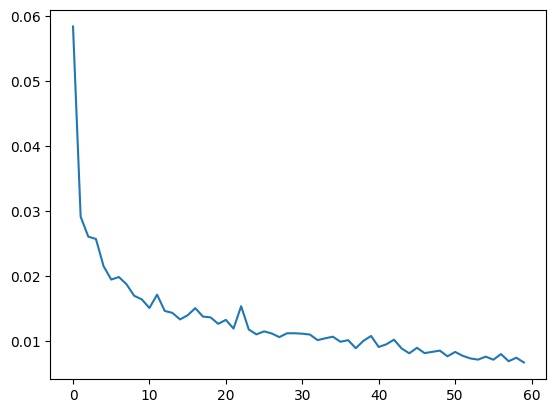

In [ ]:
# Shows loss is reducing in each epoch
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [ ]:
# Taking last 12 values in the training set to make predictions for the first value in the test set
last_train_batch = scaled_train[-12:]

In [ ]:
# Format as (1, 12, 1)
last_train_batch = last_train_batch.reshape(1, n_input, n_features)

In [ ]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 274ms/step


array([[0.55250317]], dtype=float32)

In [ ]:
scaled_test[0]

array([0.63380282])

In [ ]:
# make predictions on the testing set
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape(1, n_input, n_features)

for i in range(len(test)):
  # Get prediction value for the first batch
  current_pred = model.predict(current_batch)[0]

  # Append prediction into the array
  test_predictions.append(current_pred)

  # Use the prediction to update the batch and remove first value
  current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

1/1 [==============================] - 0s 23ms/step


In [ ]:
test_predictions

[array([0.55250317], dtype=float32),
 array([0.47717726], dtype=float32),
 array([0.41639993], dtype=float32),
 array([0.3792568], dtype=float32),
 array([0.320392], dtype=float32),
 array([0.27490437], dtype=float32),
 array([0.25792703], dtype=float32),
 array([0.25236198], dtype=float32),
 array([0.25073707], dtype=float32),
 array([0.23396395], dtype=float32),
 array([0.20685492], dtype=float32),
 array([0.17309281], dtype=float32)]

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['predictions'] = true_predictions
test

<ipython-input-31-7013f04b897b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = true_predictions


,inflation,predictions
date,,
2022-01-01,6.0,5.422772
2022-02-01,6.1,4.887959
2022-03-01,7.0,4.456439
2022-04-01,7.8,4.192723
2022-05-01,7.0,3.774783
2022-06-01,7.0,3.451821
2022-07-01,6.7,3.331282
2022-08-01,7.0,3.291770
2022-09-01,7.4,3.280233


<Axes: xlabel='date'>

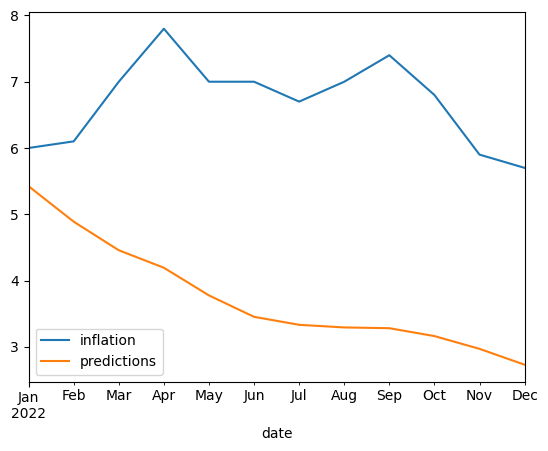

In [ ]:
test.plot()

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test['inflation'], test['predictions'] )

### **MSE for LSTM**

In [ ]:
mse

9.750728325996215

### **Random Forest Regressor**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv('inflation_data.csv', parse_dates=['date'], index_col='date')

In [ ]:
# Step 3: Create the lagged dataset
lags = 3 # number of lags to consider
cols = []
for lag in range(1, lags+1):
    col = 'lag_{}'.format(lag)
    data[col] = data['inflation'].shift(lag)
    cols.append(col)
data.dropna(inplace=True)

In [ ]:
# Step 4: Split the data into train and test sets
X = data[cols]
y = data['inflation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# Step 5: Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Step 6: Make predictions on the test set
y_pred = rf.predict(X_test)

In [ ]:
# Step 7: Evaluate the performance of the model
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 0.9318339047619029


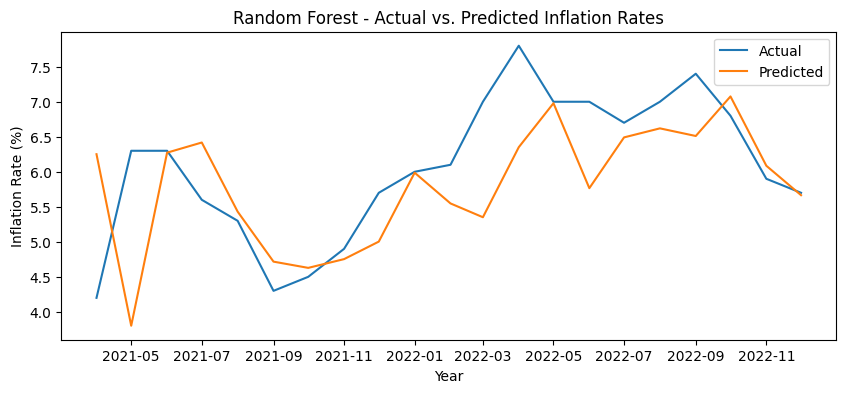

In [ ]:
# Step 8: Plot the actual and predicted values
plt.figure(figsize=(10, 4))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title('Random Forest - Actual vs. Predicted Inflation Rates')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.show()

### **Support Vector Regressor**

In [ ]:
from sklearn.svm import SVR

In [ ]:
data = pd.read_csv('inflation_data.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'inflation_data.csv'

In [ ]:
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

In [ ]:
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

In [ ]:
# Scale the data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [ ]:
#  Create the feature set and target set
def create_sets(data, n_steps):
  X, y = [], []
  for i in range(len(data)-n_steps-1):
    X.append(data[i:(i+n_steps), 0])
    y.append(data[i+n_steps, 0])
  return np.array(X), np.array(y)

n_steps = 3
X_train, y_train = create_sets(train_data, n_steps)
X_test, y_test = create_sets(test_data, n_steps)

In [ ]:
# Train the SVR model
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1]}
grid = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5)
grid.fit(X_train, y_train)
model = grid.best_estimator_

NameError: name 'SVR' is not defined

In [ ]:
# Predict the inflation values
y_pred = model.predict(X_test)

In [ ]:
# transform the predicted and actual values back to their original scale
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

NameError: name 'scaler' is not defined

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.41335348074523354


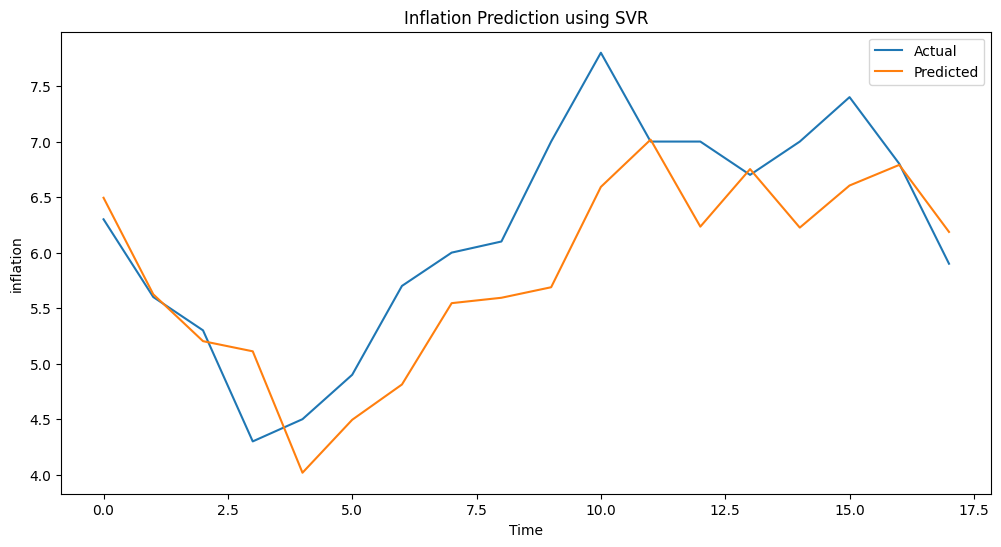

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Inflation Prediction using SVR')
plt.xlabel('Time')
plt.ylabel('inflation')
plt.legend()
plt.show()

### **SARIMA**

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.0 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima

In [ ]:
data = pd.read_csv('inflation_data.csv')

In [ ]:
data.head()

,date,inflation
0,1/1/2014,8.6
1,2/1/2014,7.9
2,3/1/2014,8.2
3,4/1/2014,8.5
4,5/1/2014,8.3


In [ ]:
data.index = pd.to_datetime(data.date)

In [ ]:
data.drop(['date'], axis=1, inplace=True)

In [ ]:
data.head()

,inflation
date,
2014-01-01,8.6
2014-02-01,7.9
2014-03-01,8.2
2014-04-01,8.5
2014-05-01,8.3


In [ ]:
train = data.loc['2014-01-01':'2020-12-01']
test = data.loc['2021-01-01':]

In [ ]:
stepwise_model = auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=320.669, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=248.318, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.52 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=320.432, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=233.619, Time=0.42 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.05 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.70 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=231.972, Time=0.27 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=246.381, Time=0.11 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.46 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=233.340, Time=0.68 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=233.944, Time=1.25 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=233.586, Time=

In [ ]:
stepwise_model.fit(train)

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
future_forecast = stepwise_model.predict(len(test))

<Axes: xlabel='date'>

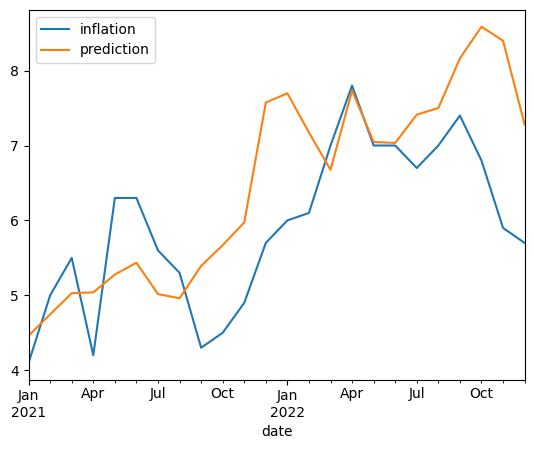

In [ ]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['prediction'])
pd.concat([test,future_forecast],axis=1).plot()

In [ ]:
# Evaluate the performance of the model
mse = mean_squared_error(future_forecast['prediction'], test['inflation'])
print('Mean Squared Error:', mse)

Mean Squared Error: 1.1674948981279067
